# Overview

This notebook will show you how easy it is to use Voyage AI embedding models in your AWS RAG stack and it will implement the canonical RAG stack with the AWS components shown in the following figure.  

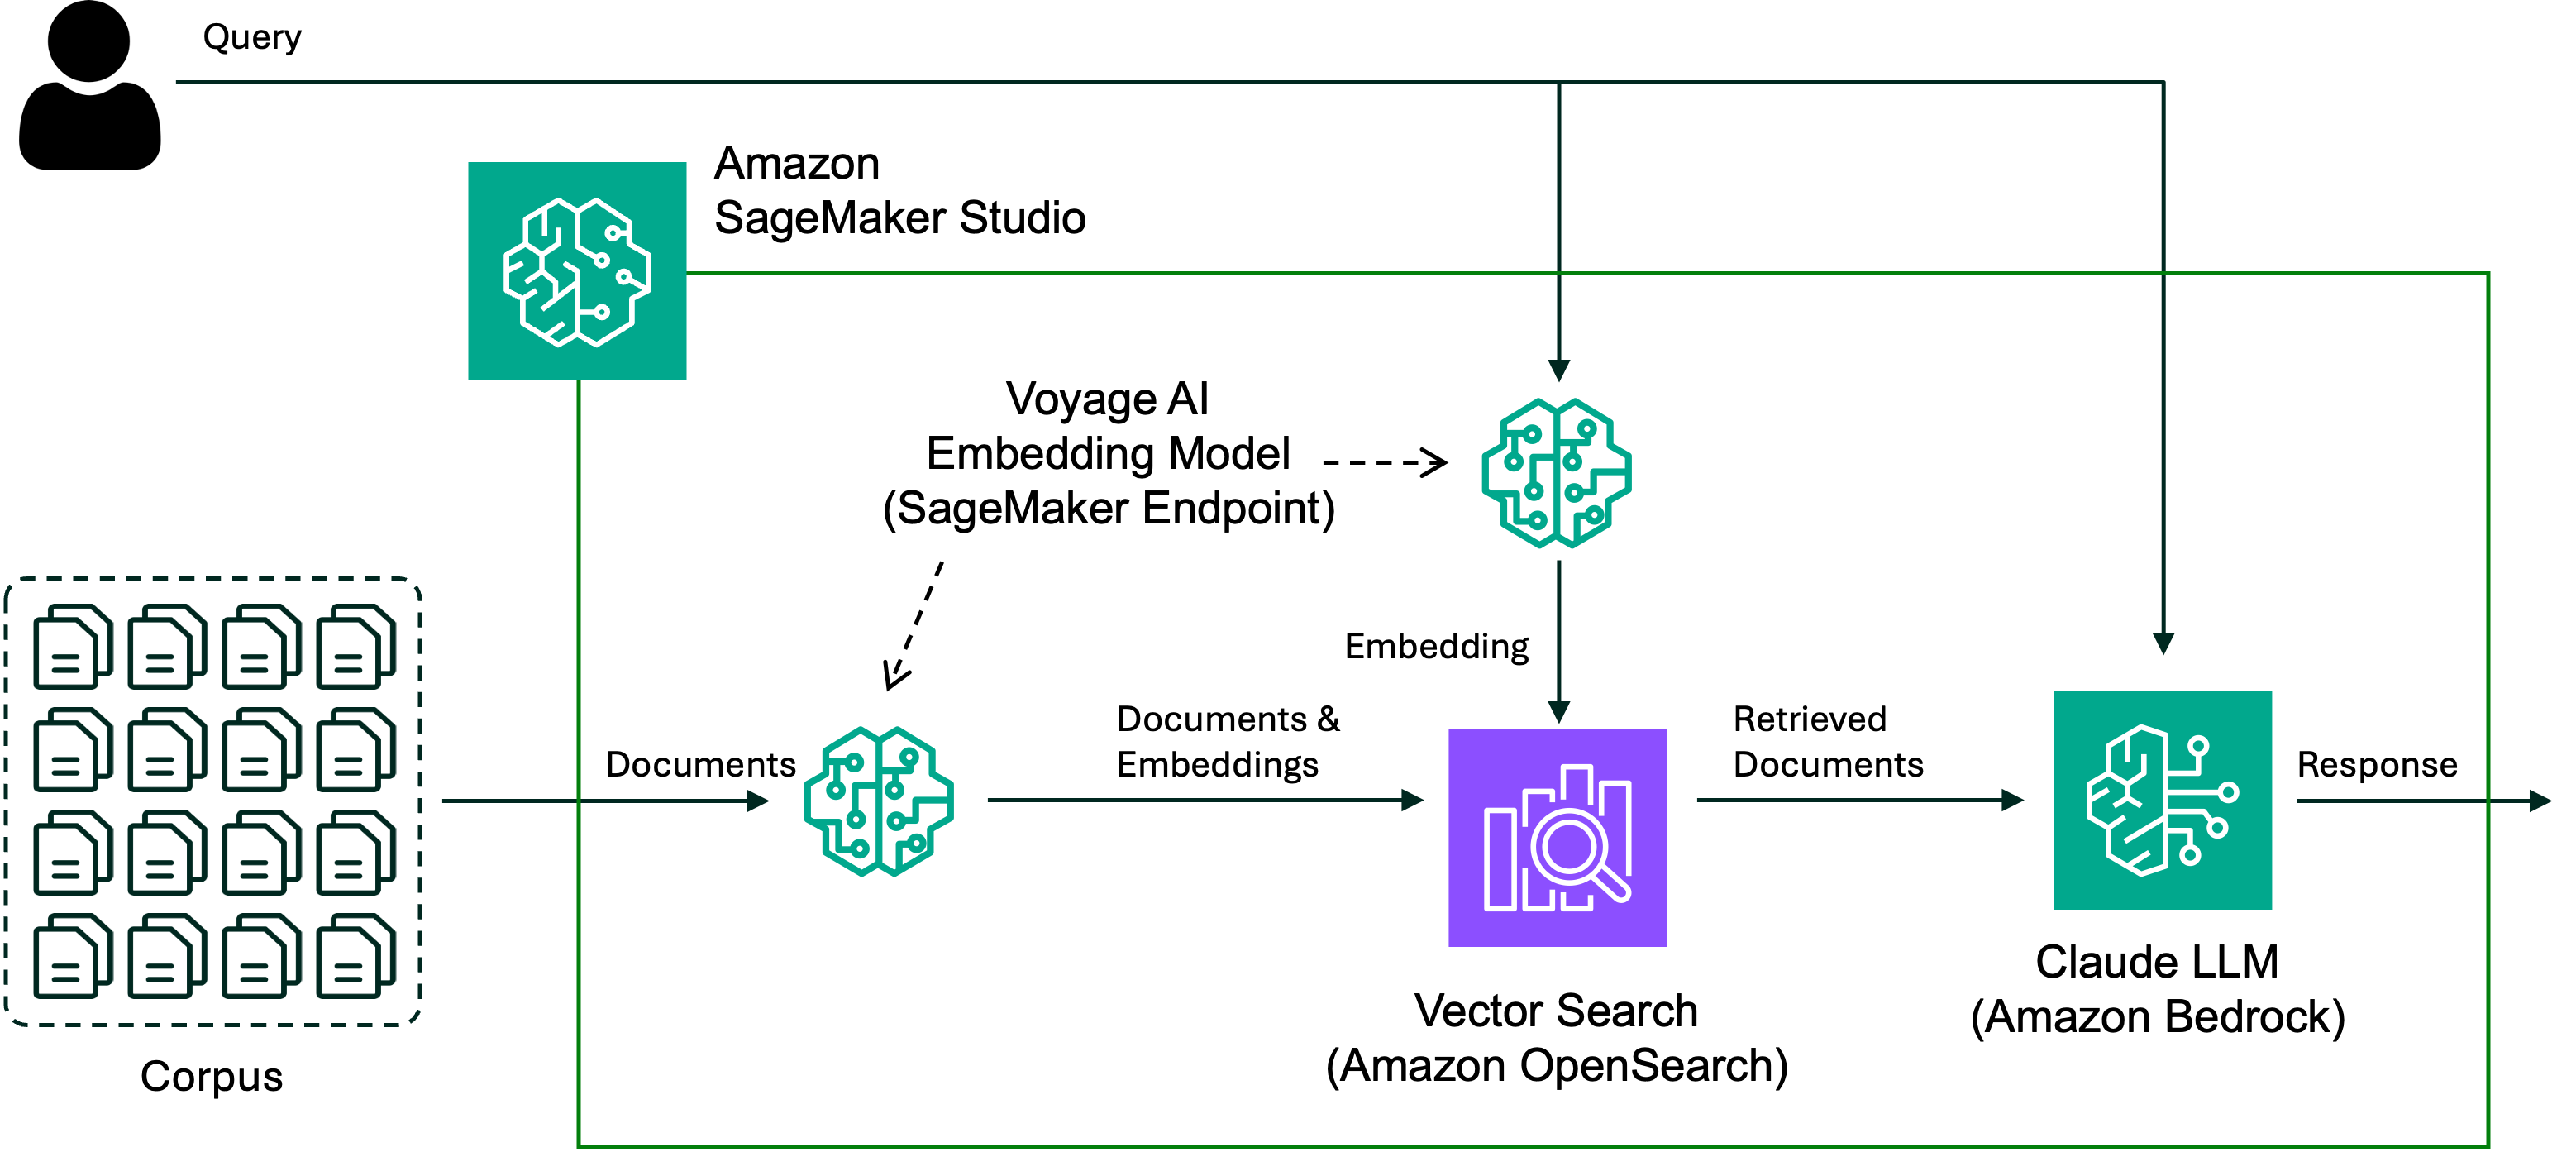

# Configurations

In [ ]:
!pip install -qU boto3
!pip install -qU python-dotenv
!pip install -qU sagemaker
!pip install -qU pypdf
!pip install -qU langchain
!pip install -qU langchain-text-splitters
!pip install -qU opensearch-py

In [ ]:
import os
import getpass
import boto3
import botocore
import json

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

This notebook assumes that sensitive information, like credentials, are specified in an `.env` file and can be loaded as environment variables (see [`python-dotenv`](https://pypi.org/project/python-dotenv/)).  However, if the environment variables are not set, you can set them in the notebook or you will be prompted to enter them in a secure way.  The expected environment variables are:

* `HOST_OPENSEARCH`: Hostname of OpenSearch service
* `USER_OPENSEARCH`: Username for OpenSearch service
* `PASS_OPENSEARCH`: Password for OpenSearch service

In [ ]:
# Set query -- this is used through the notebook
query = "What is the aggregate market value of the voting and non-voting " \
    "stock held by non-affiliates of the Registrant, as of March 25, 2022?"

# Deploy embedding endpoint

In [ ]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

In [ ]:
# See valid model IDs from Voyage AI
filter_value = "framework == voyage"
print(list_jumpstart_models(filter=filter_value))

 We’ll be using `voyage-large-2` embedding model (with JumpStart `model_id` of `voyage-large-2-embedding`), a powerful generalist model with a 16K context length.  If not already done so, we will need to subscribe to the SageMaker model package in the AWS Marketplace.  Instructions to subscribe can be found [here](https://docs.voyageai.com/docs/deploy-voyage-model-packages-from-aws-marketplace).

In [ ]:
# Set embedding endpoint configuration
(embedding_model_id, embedding_model_version, embedding_instance_type) = (
    "voyage-large-2-embedding",
    "*",
    "ml.g5.xlarge",  # See AWS Marketplace model package for supported instance types
)

In [ ]:
# Instantiate embedding model from JumpStart
from sagemaker.jumpstart.model import JumpStartModel

embedding_model = JumpStartModel(
    model_id=embedding_model_id,
    model_version=embedding_model_version,
    instance_type=embedding_instance_type,
)

In [ ]:
# Deploy model as inference endpoint. This can take several minutes to deploy (5 to 10 minutes)
embedding_endpoint = embedding_model.deploy()

# Verify embedding endpoint inference

Let's quickly verify the embedding endpoint by vectorizing our query.  In addition, we can get the embedding dimension, which we'll need to properly index vectors in the vector store later.  For `voyage-large-2`, the embedding dimension is 1536.  You can get details about all Voyage AI embedding models, including their embedding dimensions, [here](https://docs.voyageai.com/docs/embeddings). 

In [ ]:
query_vectorize_payload = {
    "input": [query],
    "input_type": "query",
    "truncation": "true",
}

# Vectorize query
embed_query_response = embedding_endpoint.predict(
    json.dumps(query_vectorize_payload)
)

# Cast vector elements to float
query_embedding = [
    float(e) for e in embed_query_response["data"][0]["embedding"]
]

EMBEDDING_DIM = len(query_embedding)
print("Embedding dimension: " + str(EMBEDDING_DIM))

In [ ]:
# Print few values of the embedding response
query_embedding[0:10]

# Load vector store

We are using the [Apple 2022 SEC Form 10-K](https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/b4266e40-1de6-4a34-9dfb-8632b8bd57e0.pdf) as our document source.  That 10-K provides the necessary context to answer our query, which was pulled from a [finance QA benchmark (FinQABench)](https://huggingface.co/datasets/lighthouzai/finqabench) data set. 

## Load documents

There are several ways you can load and preprocess documents for embedding and indexing.  In our case, with a single PDF, a straightforward way is to break up the PDF into small "chunks".

In this walkthrough, we load and chunk the source PDF file with the LangChain [PyPDFLoader](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf) (which uses [pypdf](https://pypi.org/project/pypdf/)) and [recursive character text splitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter).  The loader splits our source PDF in 1000-character chunks (`chunk_size=1000`) with a 100-character overlap between chunks (`chunk_overlap=100`).  The chunks are returned as a list of strings. 

In [ ]:
# Load and chunk source document
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = PyPDFLoader("apple-10k-2022.pdf")
document_chunks = loader.load_and_split(
    RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
        length_function=len,
        is_separator_regex=False,
    )
)

In [ ]:
# Check number of document chunks
print(len(document_chunks))

In [ ]:
# Extract content and see a sample
chunk_list = [x.page_content for x in document_chunks]
print(chunk_list[0])

## Vectorize documents

We can now vectorize our documents — or more precisely, our document chunks.  We'll want to submit our requests in batches for efficiency.  For our chunks and embedding model, we've set a good batch size of 45 below.

In practice, you may need to play with this.  For performance and infrastructure capacity reasons, each model has a maximum number of documents---which are our document chunks---and total number of tokens it can support.  See the [AWS marketplace product page for your Voyage AI model](https://aws.amazon.com/marketplace/seller-profile?id=seller-snt4gb6fd7ljg) for these limits.  For example, for [voyage-large-2](https://aws.amazon.com/marketplace/pp/prodview-erofjpgna7gtq?sr=0-3&ref_=beagle&applicationId=AWSMPContessa), the maximum of number of documents is 128 and the maximum total number of tokens in a request is 32K.  For small chunk sizes, you can probably set the `BATCH_SIZE` to 128 and not worry about hitting the maximum total token limit.

In [ ]:
# Set batch size
BATCH_SIZE = 45

In [ ]:
# Vectorize chunks in batches
index_list = []
for i in range(0, len(chunk_list), BATCH_SIZE):
    docs_playload = {
        "input": chunk_list[i:i + BATCH_SIZE],
        "input_type": "document",
        "truncation": "true",
    }

    embed_docs_response = embedding_endpoint.predict(json.dumps(docs_playload))

    doc_embeddings_list = [d["embedding"] for d in embed_docs_response["data"]]
    index_list += [
        {"document": document, "embedding": embedding} 
        for document, embedding in zip(chunk_list[i:i + BATCH_SIZE], doc_embeddings_list)
    ]

In [ ]:
# Verify expected number of embeddings
print(len(index_list))

In [ ]:
# Inspect first document
print(index_list[0]["document"])

In [ ]:
# Inspect the embedding of the first document
print(index_list[0]["embedding"][0:10])

## Create vector store index

### Amazon OpenSearch configurations
Update the OpenSearch configurations for your infrastructure

In [ ]:
# Update with your OpenSearch host
HOST_OPENSEARCH = ''

In [ ]:

# Set OpenSearch username
try:
    USER_OPENSEARCH = os.environ["USER_OPENSEARCH"]
except KeyError:
    USER_OPENSEARCH = getpass.getpass(
        "Please enter your OpenSearch user (hit enter): "
    )

In [ ]:
# Set OpenSearch password
try:
    PASS_OPENSEARCH = os.environ["PASS_OPENSEARCH"]
except KeyError:
    PASS_OPENSEARCH = getpass.getpass(
        "Please enter your OpenSearch password (hit enter): "
    )

In [ ]:
# Set index name
INDEX_NAME_OPENSEARCH = "voyageai-embeddings"

### Initialize client

In [ ]:
from opensearchpy import OpenSearch, RequestsHttpConnection

opensearch_client = OpenSearch(
    hosts=[{'host': HOST_OPENSEARCH, 'port': 443}],
    http_auth=(USER_OPENSEARCH, PASS_OPENSEARCH),
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)

### Create Index

In [ ]:
# If any index exists with same name, delete the index
if opensearch_client.indices.exists(index=INDEX_NAME_OPENSEARCH):
    opensearch_client.indices.delete(index=INDEX_NAME_OPENSEARCH)

In [ ]:
# Create index
if not opensearch_client.indices.exists(index=INDEX_NAME_OPENSEARCH):
    # Create indicies
    index_settings = {
        "settings": {
            "index": {
                "knn": True,
            },
        },
        "mappings": {
            "properties": {
                "id": {"type": "integer"},
                "document": {"type": "text"},
                "embedding": {
                    "type": "knn_vector",
                    "dimension": EMBEDDING_DIM,
                },
            },
        },
    }

    index_create_response = opensearch_client.indices.create(
        index=INDEX_NAME_OPENSEARCH,
        body=index_settings,
        ignore=[400],
    )
    print(index_create_response)

In [ ]:
# Populate index with document, embedding, and ID
for id, i in zip(range(0, len(index_list)), index_list):
    index_response = opensearch_client.index(
        index=INDEX_NAME_OPENSEARCH,
        body={
            "document": i["document"],
            "embedding": i["embedding"],
        },
        id=id,
        refresh=True,
    )

# Retrieve relevant documents

In [ ]:
# Set number of documents to retrieve
TOP_K = 3

In [ ]:
# Set vector search payload
vector_search_payload = {
    "size": TOP_K,
    "query": {"knn": {"embedding": {"vector": query_embedding, "k": TOP_K}}},
}

In [ ]:
vector_search_response = opensearch_client.search(
    index=INDEX_NAME_OPENSEARCH,
    body=vector_search_payload,
)

In [ ]:
# See search results
for h in vector_search_response["hits"]["hits"]:
    print("ID: ", h["_id"])
    print("Score: ", h["_score"])
    print("Document snippet: ", h["_source"]["document"][0:3000])
    print()

# Generate a retrieval-augmented response

In [ ]:
# Remind us what the original query was
print(query)

In [ ]:
# Prep retrieved documents for prompting
context_list = [
    h["_source"]["document"] for h in vector_search_response["hits"]["hits"]
]
context = str(context_list)

In [ ]:
# Create retrieval-augmented prompt
rag_prompt = f"""Human:

INSTRUCTIONS:
Answer the QUERY using the CONTEXT text provided below. Keep your answer
grounded in the facts of the CONTEXT. If the CONTEXT doesn’t contain the
facts to answer the QUERY just respond with "I do not have enough context
to respond to this query.".

QUERY: {query}

CONTEXT: {context}

Assistant:
"""

In [ ]:
rag_payload = {
    "messages": [{"role": "user", "content": rag_prompt}],
    "max_tokens": 1024,
    "anthropic_version": "bedrock-2023-05-31"
}

In [ ]:
# List available LLMs on Amazon Bedrock
bedrock_client = boto3.client('bedrock', region_name='us-east-1')
bedrock_fm = bedrock_client.list_foundation_models()
print([(m["modelId"], m["modelName"]) for m in bedrock_fm["modelSummaries"]])

In [ ]:
# Set Bedrock LLM model ID
LLM_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

In [ ]:
bedrock_runtime_client = boto3.client('bedrock-runtime', region_name='us-east-1')

In [ ]:
# Invoke LLM inference
try:
    llm_rag_response = bedrock_runtime_client.invoke_model(
        modelId=LLM_MODEL_ID,
        body=json.dumps(rag_payload),
        accept="application/json",
        contentType="application/json",
    )
except botocore.exceptions.ClientError as error:
    print("Client error")
    raise error

In [ ]:
# Print response
rag_response = json.loads(llm_rag_response.get("body").read())
print(rag_response)

# Generate a direct LLM response

For comparison, we submit the query directly to the LLM without any additional context.

In [ ]:
# Set basic prompt
prompt = f"""Human: {query}

Assistant:
"""

In [ ]:
query_payload = {
    "messages": [{"role": "user", "content": prompt}],
    "max_tokens": 1024,
    "anthropic_version": "bedrock-2023-05-31"
}

In [ ]:
# Invoke LLM inference
try:
    llm_response = bedrock_runtime_client.invoke_model(
        modelId=LLM_MODEL_ID,
        body=json.dumps(query_payload),
        accept="application/json",
        contentType="application/json",
    )
except botocore.exceptions.ClientError as error:
    print("Client error")
    raise error

In [ ]:
# Print query response
response_query = json.loads(llm_response.get("body").read())
print(response_query)

As we can see, without the additional context provided by RAG, the direct LLM response is not very helpful.  Fortunately, Claude does state it does not have enough context rather than hallucinate a blatantly incorrect answer.

# Clean up embedding endpoint

When done, be sure to clean up the embedding endpoint to not incur unnecessary charges.

In [ ]:
embedding_endpoint.delete_model()
embedding_endpoint.delete_endpoint()